In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

sns.set_theme(style="whitegrid")

## Read train dataset

In [2]:
df = pd.read_parquet('./IDS2017/Final/Combined.parquet')
print(df['Label'].value_counts())

Label
BENIGN              1014454
DoS Hulk             172846
DDoS                 128014
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Heartbleed               11
Name: count, dtype: int64


## Train model

### Tune model

In [ ]:
# Preprocess the data
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

# Split the dataset
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=8, max_value=64, step=8), 
                    input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=4, max_value=32, step=4), 
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='network_anomaly_detection'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.3)

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy: %.2f' % (accuracy * 100))

### Run model on preset parameters

Epoch 1/8


c:\Users\delve\WebstormProjects\ids2018-anomaly-detection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7308/7308 ━━━━━━━━━━━━━━━━━━━━ 7s 869us/step - accuracy: 0.9275 - loss: 0.2134 - val_accuracy: 0.9413 - val_loss: 0.1476
Epoch 2/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 861us/step - accuracy: 0.9411 - loss: 0.1450 - val_accuracy: 0.9417 - val_loss: 0.1356
Epoch 3/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 850us/step - accuracy: 0.9409 - loss: 0.1375 - val_accuracy: 0.9422 - val_loss: 0.1419
Epoch 4/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 803us/step - accuracy: 0.9412 - loss: 0.1317 - val_accuracy: 0.9420 - val_loss: 0.1174
Epoch 5/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 850us/step - accuracy: 0.9433 - loss: 0.1166 - val_accuracy: 0.9690 - val_loss: 0.1174
Epoch 6/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 813us/step - accuracy: 0.9549 - loss: 0.1059 - val_accuracy: 0.9406 - val_loss: 0.1092
Epoch 7/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 795us/step - accuracy: 0.9623 - loss: 0.0985 - val_accuracy: 0.9619 - val_loss: 0.0950
Epoch 8/8
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 6s 806us/step - accuracy: 0.9647 - loss: 0.0949 - va

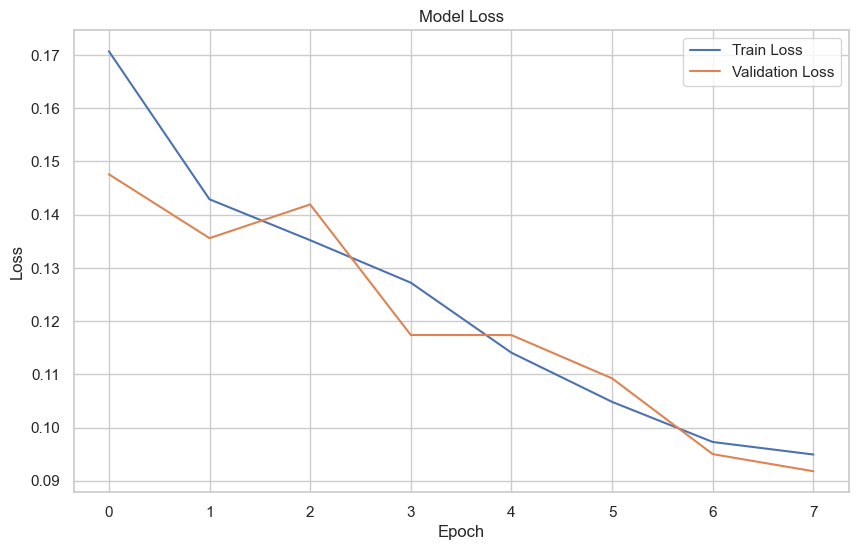

In [3]:
# Preprocess the data
df['Label'] = df['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype("int")  # BENIGN -> 1, non-BENIGN -> 0
df['Bwd Packet Length Max'] = df['Bwd Packet Length Max'].astype('int')

# Split the dataset
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential()
model.add(Dense(20, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=8,
    batch_size=128,
    validation_data=(X_test_scaled, y_test)
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Test accuracy: %.2f' % (accuracy*100))

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Read test dataset

In [4]:
df_big = pd.read_parquet('./IDS2017/Final/Combined.parquet')
df_big['Label'] = df_big['Label'].apply(lambda x: 1 if x == 'BENIGN' else 0).astype(int)  # BENIGN -> 1, non-BENIGN -> 0
df_big['Bwd Packet Length Max'] = df_big['Bwd Packet Length Max'].astype('int')
print(df_big['Label'].value_counts())

Label
1    1014454
0     321770
Name: count, dtype: int64


## Test model

### Find the best threshold

41757/41757 ━━━━━━━━━━━━━━━━━━━━ 21s 504us/step
Best Threshold: 0.76001001001001
Maximum Accuracy: 0.9632022774624613
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    321770
           1       0.98      0.97      0.98   1014454

    accuracy                           0.96   1336224
   macro avg       0.95      0.95      0.95   1336224
weighted avg       0.96      0.96      0.96   1336224



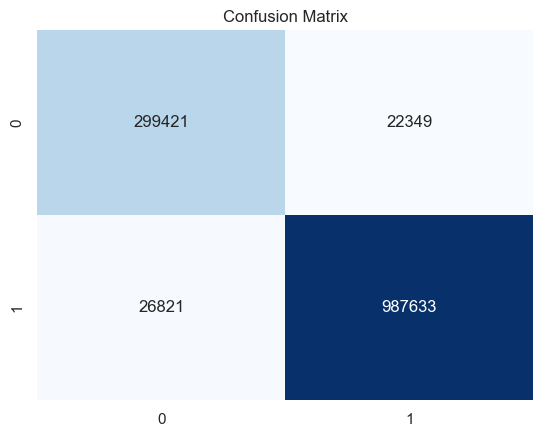

Accuracy Score:
0.9632022774624613


In [5]:
X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']
X_combined_scaled = scaler.transform(X_combined)

# Use the trained model to predict the labels of the new data
df_big['anomaly_score'] = model.predict(X_combined_scaled)

# Define the range of possible threshold values
thresholds = np.linspace(0.75, 1, 1000)
max_accuracy = 0 
best_threshold = 0

# Iterate over the possible threshold values
for threshold in thresholds:
    df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)
    accuracy = accuracy_score(y_combined, df_big['anomaly'])

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_threshold = threshold


print("Best Threshold:", best_threshold)
print("Maximum Accuracy:", max_accuracy)

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < best_threshold else 1)

print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))

### Hard coded threshold

In [ ]:
X_combined = df_big.drop('Label', axis=1)
y_combined = df_big['Label']

# Define the scaler
scaler = StandardScaler()
scaler.fit(X_combined)

# Normalize the data
X_combined_scaled = scaler.transform(X_combined)

# Use the trained model to predict the labels of the new data
df_big['anomaly_score'] = model.predict(X_combined_scaled)

threshold = 0.7987987987987988

df_big['anomaly'] = df_big['anomaly_score'].apply(lambda x: 0 if x < threshold else 1)

print(df_big['anomaly'].value_counts())
print(df_big['anomaly_score'].min(), df_big['anomaly_score'].max())

# Compare the predicted labels with the actual labels
print("Classification Report:")
print(classification_report(y_combined, df_big['anomaly']))

sns.heatmap(confusion_matrix(y_combined, df_big['anomaly']), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

print("Accuracy Score:")
print(accuracy_score(y_combined, df_big['anomaly']))